In [1]:
import yfinance as yf
import pandas as pd

In [2]:
# accessing S&P500 data using yahoo finance API
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period='max')

<Axes: xlabel='Date'>

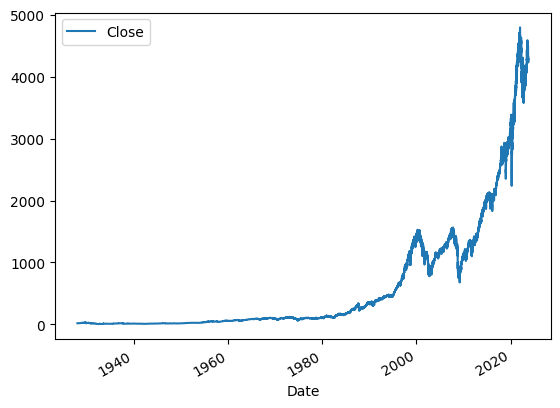

In [3]:
# plotting historical close price over time
sp500.plot.line(y="Close",use_index=True)

In [4]:
# cleaning data - deleting unwanted columns
del sp500["Dividends"]
del sp500["Stock Splits"]

In [5]:
# shifted columns up to show historically what the next day's price was
sp500["Future Price (Tomorrow)"] = sp500["Close"].shift(-1)
sp500

,Open,High,Low,Close,Volume,Future Price (Tomorrow)
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2023-10-02 00:00:00-04:00,4284.520020,4300.580078,4260.209961,4288.390137,3938660000,4229.450195
2023-10-03 00:00:00-04:00,4269.750000,4281.149902,4216.450195,4229.450195,3953830000,4263.750000
2023-10-04 00:00:00-04:00,4233.830078,4268.500000,4220.479980,4263.750000,3777600000,4258.189941


In [6]:
# add a column to indicated if stock price went up or not
sp500["Price Increase?"] = (sp500["Future Price (Tomorrow)"] > sp500["Close"]).astype(int)


In [7]:
# discard all data before 1990
sp500 = sp500.loc["1990-01-01":].copy()

In [8]:
def predict(train,test,predictors, model):
     model.fit(train[predictors], train["Price Increase?"])

     preds = model.predict_proba(test[predictors])[:,1]
     preds[preds >= 0.6] = 1 # be more confident about price going up
     preds[preds < 0.6] = 0
     preds = pd.Series(preds, index=test.index, name = "Predictions")

     combined = pd.concat([test["Price Increase?"], preds], axis=1)
     return combined

# ~250 trading days per year, so train on 10 years of data
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy() # train throughout the years 
        test = data.iloc[i:(i+step)] # test against next year
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [9]:
horizons = [2,5,60,250,1000]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close Ratio {horizon}"
    sp500[ratio_column] = sp500["Close"]/rolling_averages["Close"]

    trend_column = f"Trend {horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Price Increase?"]

    new_predictors += [ratio_column, trend_column]

In [10]:
sp500 = sp500.dropna()

In [11]:
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [12]:
predictions = backtest(sp500, model, new_predictors)

In [15]:
print(predictions["Predictions"].value_counts())
precision_score(predictions["Price Increase?"], predictions["Predictions"])

Predictions
0.0    5004
1.0       2
Name: count, dtype: int64


1.0